<a href="https://colab.research.google.com/github/santiagonajera/optimizacionInventrios/blob/main/ABC_XYZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

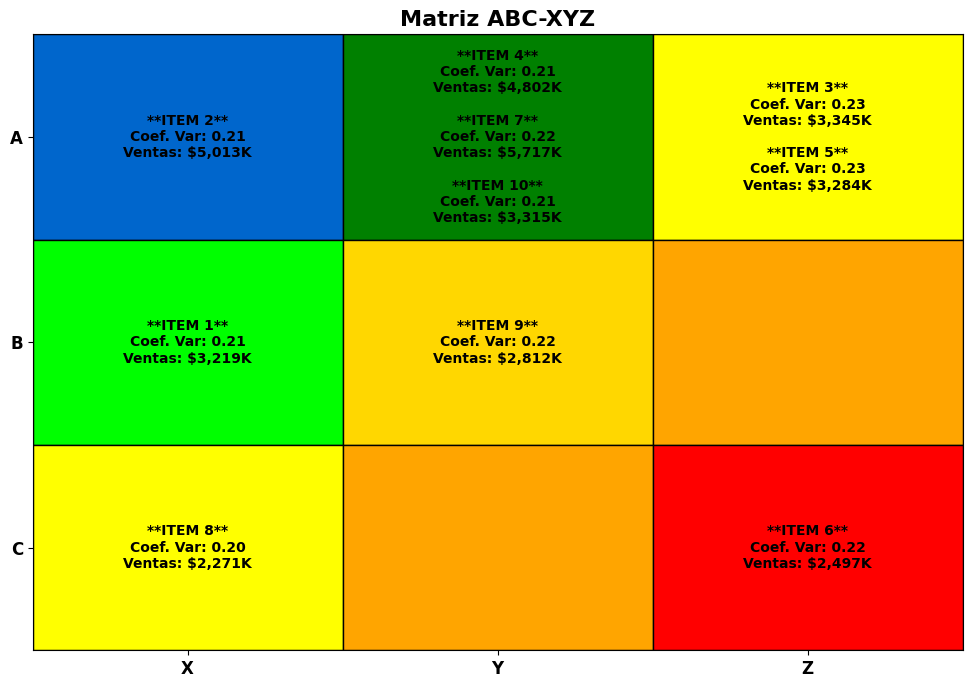

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Ruta del archivo desde GitHub
file_path = 'https://raw.githubusercontent.com/santiagonajera/optimizacionInventrios/main/EjemploClases-Eco.xlsx'

# Cargar las hojas relevantes
historical_data = pd.read_excel(file_path, sheet_name='Historico')
forecast_data = pd.read_excel(file_path, sheet_name='Forecast')
price_cost_data = pd.read_excel(file_path, sheet_name='Precios-Costos')

# Asegurar consistencia en nombres de columnas
historical_data.rename(columns={"ITEM": "Ítem"}, inplace=True)
forecast_data.rename(columns={"ITEM": "Ítem"}, inplace=True)
price_cost_data.rename(columns={"ITEM": "Ítem"}, inplace=True)

# Clasificación XYZ
last_18_months = historical_data.iloc[:, -18:]
historical_data["Coeficiente de Variación"] = last_18_months.std(axis=1) / last_18_months.mean(axis=1)
percentiles = historical_data["Coeficiente de Variación"].quantile([0.33, 0.67]).values
conditions_xyz = [
    (historical_data["Coeficiente de Variación"] <= percentiles[0]),
    (historical_data["Coeficiente de Variación"] > percentiles[0]) &
    (historical_data["Coeficiente de Variación"] <= percentiles[1]),
    (historical_data["Coeficiente de Variación"] > percentiles[1])
]
categories_xyz = ["X", "Y", "Z"]
historical_data["Clasificación XYZ"] = np.select(conditions_xyz, categories_xyz)

# Clasificación ABC
forecast_data["Unidades Totales Proyectadas"] = forecast_data.iloc[:, 1:].sum(axis=1)
merged_data = pd.merge(forecast_data[["Ítem", "Unidades Totales Proyectadas"]],
                       price_cost_data[["Ítem", "Precio"]], on="Ítem")
merged_data["Ventas Totales en Dólares"] = merged_data["Unidades Totales Proyectadas"] * merged_data["Precio"]
merged_data = merged_data.sort_values(by="Ventas Totales en Dólares", ascending=False)
categories_abc = ["A", "B", "C"]
merged_data["Categoría ABC"] = pd.cut(merged_data["Ventas Totales en Dólares"].rank(ascending=False),
                                      bins=[0, 0.6 * len(merged_data), 0.8 * len(merged_data), len(merged_data)],
                                      labels=categories_abc, include_lowest=True)

# Fusionar ambas clasificaciones
final_data = pd.merge(historical_data[["Ítem", "Clasificación XYZ", "Coeficiente de Variación"]],
                      merged_data[["Ítem", "Categoría ABC", "Unidades Totales Proyectadas", "Ventas Totales en Dólares"]], on="Ítem")
# Convertir las columnas categóricas a strings antes de concatenar
final_data["Clasificación ABC-XYZ"] = final_data["Categoría ABC"].astype(str) + "-" + final_data["Clasificación XYZ"].astype(str)

# Crear matriz ABC-XYZ
abc_xyz_matrix = pd.DataFrame(index=["A", "B", "C"], columns=["X", "Y", "Z"])
for _, row in final_data.iterrows():
    abc = row["Categoría ABC"]
    xyz = row["Clasificación XYZ"]
    ventas_miles = int(row["Ventas Totales en Dólares"] / 1000)  # Convertir a miles
    item_info = (
        f"**{row['Ítem']}**\n"
        f"Coef. Var: {row['Coeficiente de Variación']:.2f}\n"
        f"Ventas: ${ventas_miles:,}K"
    )
    if pd.isnull(abc_xyz_matrix.at[abc, xyz]):
        abc_xyz_matrix.at[abc, xyz] = item_info
    else:
        abc_xyz_matrix.at[abc, xyz] += "\n\n" + item_info

# Graficar la matriz ABC-XYZ
plt.figure(figsize=(12, 8))
ax = plt.gca()
colors = {
    ("A", "X"): '#0066CC', ("A", "Y"): '#008000', ("A", "Z"): '#FFFF00',
    ("B", "X"): '#00FF00', ("B", "Y"): '#FFD700', ("B", "Z"): '#FFA500',
    ("C", "X"): '#FFFF00', ("C", "Y"): '#FFA500', ("C", "Z"): '#FF0000'
}
for i, abc in enumerate(["A", "B", "C"]):
    for j, xyz in enumerate(["X", "Y", "Z"]):
        color = colors.get((abc, xyz), '#FFFFFF')
        rect = Rectangle((j, i), 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        text = abc_xyz_matrix.at[abc, xyz]
        if not pd.isnull(text):
            ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
                    fontsize=10, fontweight='bold', wrap=True)

# Ajustes finales de la gráfica
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.xticks([0.5, 1.5, 2.5], ["X", "Y", "Z"], fontsize=12, fontweight='bold')
plt.yticks([0.5, 1.5, 2.5], ["A", "B", "C"], fontsize=12, fontweight='bold')
plt.title("Matriz ABC-XYZ", fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()
